In [30]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt


In [39]:
from sklearn.preprocessing import StandardScaler
from scipy import stats

def preprocess_data(data_path, labels_path=None):
    features = ['reanalysis_specific_humidity_g_per_kg', 
                 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c',
                'station_min_temp_c',
#                 'precipitation_amt_mm', 
                'week_start_date']
    df = pd.read_csv(data_path, index_col=[0, 1, 2])
            
    df['station_avg_temp_c_mv_avg'] = df['station_avg_temp_c'].rolling(window=35).mean()
    df['precipitation_amt_mm_mv_avg'] = df['precipitation_amt_mm'].rolling(window=35).mean()
    features.append('station_avg_temp_c_mv_avg')
    features.append('precipitation_amt_mm_mv_avg')
    
    df.fillna(method='ffill', inplace=True)
    df = df.fillna(df.mean())
    
    df['week_start_date'] = pd.to_datetime(df['week_start_date'])
    for i in range(1,5):
        df['quarter_' + str(i)] = df['week_start_date'].apply(lambda date: 1 if (
            ((i-1)*3<date.to_datetime().month) and (date.to_datetime().month <= i * 3)) else 0)
        features.append('quarter_' + str(i))
    
    df = df.drop(['week_start_date'], axis=1)
    features.remove('week_start_date')
    df = df[features]    
    sj_label = None
    iq_label = None
    # add labels to dataframe
    if labels_path:
        labels = pd.read_csv(labels_path, index_col=[0, 1, 2]).loc[df.index]
        sj_label = pd.DataFrame(labels.loc['sj'])
        iq_label = pd.DataFrame(labels.loc['iq'])

    sj = pd.DataFrame(df.loc['sj'])
    iq = pd.DataFrame(df.loc['iq'])
    
    
    return sj, iq, sj_label, iq_label

In [40]:
sj_train, iq_train, sj_label, iq_label = preprocess_data('./data/train_features.csv', './data/train_labels.csv')
print(sj_train.shape)
sj_train.head()


(936, 10)


/usr/local/lib/python3.5/dist-packages/pandas/core/series.py:2551: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  mapped = lib.map_infer(values, f, convert=convert_dtype)


reanalysis_specific_humidity_g_per_kg  \
year weekofyear                                          
1990 18                                      14.012857   
     19                                      15.372857   
     20                                      16.848571   
     21                                      16.672857   
     22                                      17.210000   

                 reanalysis_dew_point_temp_k  station_avg_temp_c  \
year weekofyear                                                    
1990 18                           292.414286           25.442857   
     19                           293.951429           26.714286   
     20                           295.434286           26.714286   
     21                           295.310000           27.471429   
     22                           295.821429           28.942857   

                 station_min_temp_c  station_avg_temp_c_mv_avg  \
year weekofyear                                                  
1990 18                        20.0                   27.28741   
     19                        22.2                   27.28741   
     20                        22.8                   27.28741   
     21                        23.3                   27.28741   
     22                        23.9                   27.28741   

                 precipitation_amt_mm_mv_avg  quarter_1  quarter_2  quarter_3  \
year weekofyear                                                                 
1990 18                            46.121045          0          1          0   
     19                            46.121045          0          1          0   
     20                            46.121045          0          1          0   
     21                            46.121045          0          1          0   
     22                            46.121045          0          1          0   

                 quarter_4  
year weekofyear             
1990 18                  0  
     19                  0  
     20                  0  
     21                  0  
     22                  0

In [41]:
from sklearn.model_selection import train_test_split

# split data into training and validation data, for both predictors and target
# The split is based on a random number generator. Supplying a numeric value to
# the random_state argument guarantees we get the same split every time we
# run this script.

# sj_train.head()

sj_train_X, sj_test_X, sj_train_y, sj_test_y = train_test_split(sj_train, sj_label['total_cases'], test_size=0.1, random_state=0, shuffle=False)

iq_train_X, iq_test_X, iq_train_y, iq_test_y = train_test_split(iq_train, iq_label['total_cases'], test_size=0.25, random_state=0, shuffle=False)

In [42]:
def find_best_model(sj_train_X, sj_test_X, sj_train_y, sj_test_y, iq_train_X, iq_test_X, iq_train_y, iq_test_y):
    best_sj_model = None
    sj_error = 1000
    for i in range (10):
        
        sj_model = RandomForestRegressor(n_estimators=200, max_depth=6,
                                         criterion='mae', warm_start=True)

        sj_model.fit(sj_train_X, sj_train_y)
        sj_pred_val = sj_model.predict(sj_test_X)
        error = mean_absolute_error(sj_test_y, sj_pred_val)
        print ("SJ "+str(i)+" : "+str(error))
        if error < sj_error:
            best_sj_model = sj_model
            sj_error = error

    print("SJ " + str(sj_error))
    
    best_iq_model = None 
    iq_error = 1000
    for i in range(10):
        
        iq_model = RandomForestRegressor(n_estimators=20, max_features='auto',
                                         max_depth=6, min_samples_leaf=0.005,
                                         criterion='mae', min_weight_fraction_leaf=0.1
                                        , warm_start=True)
        iq_model.fit(iq_train_X, iq_train_y)
        iq_pred_val = iq_model.predict(iq_test_X)
        error = mean_absolute_error(iq_test_y, iq_pred_val)
        print("IQ "+str(i)+" : "+str(error))
        if error < iq_error:
            best_iq_model  = iq_model 
            iq_error = error
    print("IQ " + str(iq_error))
    
    return best_sj_model, best_iq_model

sj_model, iq_model = find_best_model(sj_train_X, sj_test_X, sj_train_y, sj_test_y, iq_train_X, iq_test_X, iq_train_y, iq_test_y)


SJ 0 : 16.860531914893617
SJ 1 : 17.090212765957446
SJ 2 : 16.908803191489362
SJ 3 : 17.308723404255318
SJ 4 : 17.462021276595742
SJ 5 : 17.36561170212766
SJ 6 : 16.971622340425533
SJ 7 : 16.909069148936165
SJ 8 : 17.083537234042552
SJ 9 : 17.235638297872338
SJ 16.860531914893617
IQ 0 : 9.24480769230769
IQ 1 : 8.825576923076923
IQ 2 : 9.192884615384614
IQ 3 : 9.327115384615384
IQ 4 : 9.424615384615382
IQ 5 : 9.237692307692308
IQ 6 : 9.059807692307693
IQ 7 : 9.260961538461538
IQ 8 : 9.36173076923077
IQ 9 : 9.379807692307692
IQ 8.825576923076923


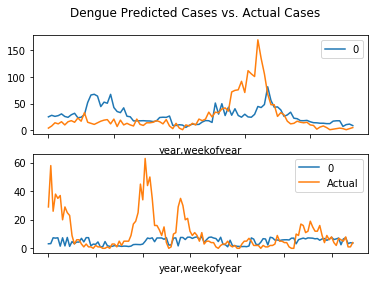

In [25]:
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
pd.DataFrame(sj_pred_val).plot(ax=axes[0], label="Predictions")
sj_test_y.plot(ax=axes[0], label="Actual")

# plot iq
pd.DataFrame(iq_pred_val).plot(ax=axes[1], label="Predictions")
iq_test_y.plot(ax=axes[1], label="Actual")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()

In [26]:

sj_test, iq_test, sj_test_label, iq_test_label = preprocess_data('./data/dengue_features_test.csv')

sj_predictions = sj_model.predict(sj_test).astype(int)
iq_predictions = iq_model.predict(iq_test).astype(int)

submission = pd.read_csv("./data/submission .csv", index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])

submission.to_csv("./results/3_submission_latest.csv")

/usr/local/lib/python3.5/dist-packages/pandas/core/series.py:2551: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  mapped = lib.map_infer(values, f, convert=convert_dtype)


Comparison : MAE : 31.064903846153847


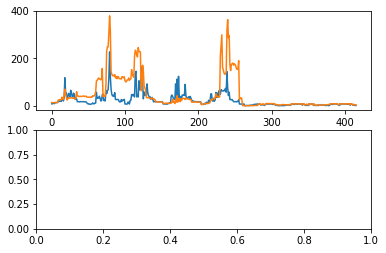

In [29]:
benchmark = pd.read_csv('./results/best.csv')
submission = pd.read_csv('./results/3_submission_latest.csv')


# adder = lambda x: x + 10
# formated_total_cases = submission['total_cases'].apply(adder)

# print(formated_total_cases)

figs, axes = plt.subplots(nrows=2, ncols=1)

# # submission = submission.iloc[50:]
# plot sj
benchmark.total_cases.plot(ax=axes[0], label="Actual")
submission.total_cases.plot(ax=axes[0], label="Predictions")
    

# plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
# plt.legend()

# plt.show()

print("Comparison : MAE : " + str(mean_absolute_error(benchmark.total_cases, submission.total_cases)))